In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from sklearn.metrics import confusion_matrix



In [2]:
train_df = pd.read_csv('GA2Datasets/UNSW_NB15_training-set.csv')
test_df = pd.read_csv('GA2Datasets/UNSW_NB15_testing-set.csv')

### Custom pipeline for data pre-processing

In [3]:
class PreProcessPipeline:
    def __init__(self, label_encode = True, process_label = 'Binary'):
        self.label_encode = label_encode
        self.process_label = process_label
    
    def fit(self):
        return self

    def transform(self, df):
        df = df.drop('id', axis=1)
        df = df.copy()
        if self.label_encode:
            columns = ['proto', 'service', 'state', 'attack_cat']
            for column in columns:
                unique_values = df[column].unique()
                mapping = {value: index for index, value in enumerate(unique_values)}
                df[column] = df[column].map(mapping)

        if self.process_label == 'Binary':
            df.drop('attack_cat', axis=1, inplace=True)
        else:             
            df['attack_cat'], df['label'] = df['label'], df['attack_cat']
            print('change name')
            df.drop('attack_cat', axis=1, inplace=True)      

        return df

Dataframe Pipeline

In [4]:
'''
Author: Khanh Nguyen
Name: PySpark Dataframe Pipeline
Description:
    This class is used to create a pipeline for PySpark dataframe, accept 2 boolean parameter: smote & standardize.
    Features 
        (Default)
        - Resample: Resample the dataframe
        - Vectorize: Vectorize the dataframe
        (activate by setting the parameter to True):
        - SMOTE: Oversampling the minority class
        - Standardize: Standardize the dataframe using z-score
'''

from pyspark.sql.functions import col
class SparkDFPipeline:
    def __init__(self, smote=False, standardize=False):
        self.smote = smote
        self.standardize = standardize
    
    def fit(self):
        return self
    
    def transform(self, train_df, test_df):
        if self.smote:
            majority = train_df.filter(col('label') == 0)
            minority = train_df.filter(col('label') == 1)

            majority_count = majority.count()
            minority_count = minority.count()

            ratio = int(majority_count / minority_count)
            sample_num = int(ratio * minority_count) - minority_count
            sample = minority.sample(True, sample_num / minority_count, seed=42)
            balanced_sample = minority.union(sample)
            train_df = majority.union(balanced_sample).orderBy('label')
        
        if self.standardize:
            # Standardize the df

            # Resample the df
            num_partitions = 500
            repartitioned_df = train_df.repartition(num_partitions)

            exclude = ['proto', 'service', 'state']
            input_columns = train_df.columns[:-1]
            selected_columns = [col for col in input_columns if col not in exclude]
            # Vectorize the df
            assembler = VectorAssembler(inputCols=selected_columns, outputCol='features')
            train_df = assembler.transform(repartitioned_df)
            test_df = assembler.transform(test_df)

            # Standardize the df
            scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
            scaler_model = scaler.fit(train_df)
            train_df = scaler_model.transform(train_df)

            scaler_model = scaler.fit(test_df)
            test_df = scaler_model.transform(test_df)
            test_df = test_df.drop('features')
            train_df = train_df.drop('features')
            
            # put back the categorical columns
            input_cols = ['scaled_features', 'proto', 'service', 'state']
            output_col = "features"
            assembler1 = VectorAssembler(inputCols=input_cols, outputCol=output_col)
            train_df = assembler1.transform(train_df)
            test_df = assembler1.transform(test_df)

            # return result
            test_df = test_df.select('features', 'label')
            train_df = train_df.select('features', 'label')
        else:
            # Normal vectorize df
            num_partitions = 500
            repartitioned_df = train_df.repartition(num_partitions)
            input_columns = train_df.columns[:-1]
            assembler = VectorAssembler(inputCols=input_columns, outputCol='features')
            train_df = assembler.transform(repartitioned_df)
            train_df = train_df.select('features', 'label')
            test_df = assembler.transform(test_df)
              
        return train_df, test_df


## Pipeline trigger example
# pipeline = SparkDFPipeline(smote=False, standardize=False)
# train, test = pipeline.transform(sparktrain_df, sparktest_df)

For Evaluation

In [5]:
def evaluate_model(model, val_data):
    # Make predictions on the validation data
    predictions = model.transform(val_data)

    # Evaluate the model using a BinaryClassificationEvaluator for AUC
    auc_evaluator = BinaryClassificationEvaluator(labelCol='label')
    auc = auc_evaluator.evaluate(predictions)

    # Evaluate the model using a BinaryClassificationEvaluator for areaUnderPR
    pr_evaluator = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderPR')
    area_under_pr = pr_evaluator.evaluate(predictions)

    # Calculate additional metrics
    sensitivity = predictions.filter("label = 1 and prediction = 1").count() / predictions.filter("label = 1").count()
    specificity = predictions.filter("label = 0 and prediction = 0").count() / predictions.filter("label = 0").count()
    precision = predictions.filter("prediction = 1").count() / predictions.filter("prediction = 1 or prediction = 0").count()
    recall = sensitivity
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = (predictions.filter("label = prediction").count()) / predictions.count()
    # youdens_j = sensitivity + specificity - 1
    # balanced_accuracy = (sensitivity + specificity) / 2

    # Create a dictionary of model evaluation metrics
    eval_metrics = {
        'AUC': auc,
        'AreaUnderPR': area_under_pr,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score,
        'Accuracy': accuracy,
        # "Youden's J Index": youdens_j,
        # 'Balanced Accuracy': balanced_accuracy
    }

    return eval_metrics

## Data Exploration

In [6]:
train_df.isnull().sum()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

In [7]:
pipeline = PreProcessPipeline(label_encode=True, process_label='Multi')
train_df = pipeline.transform(train_df)
test_df = pipeline.transform(test_df)

change name
change name


## Data Visualisation

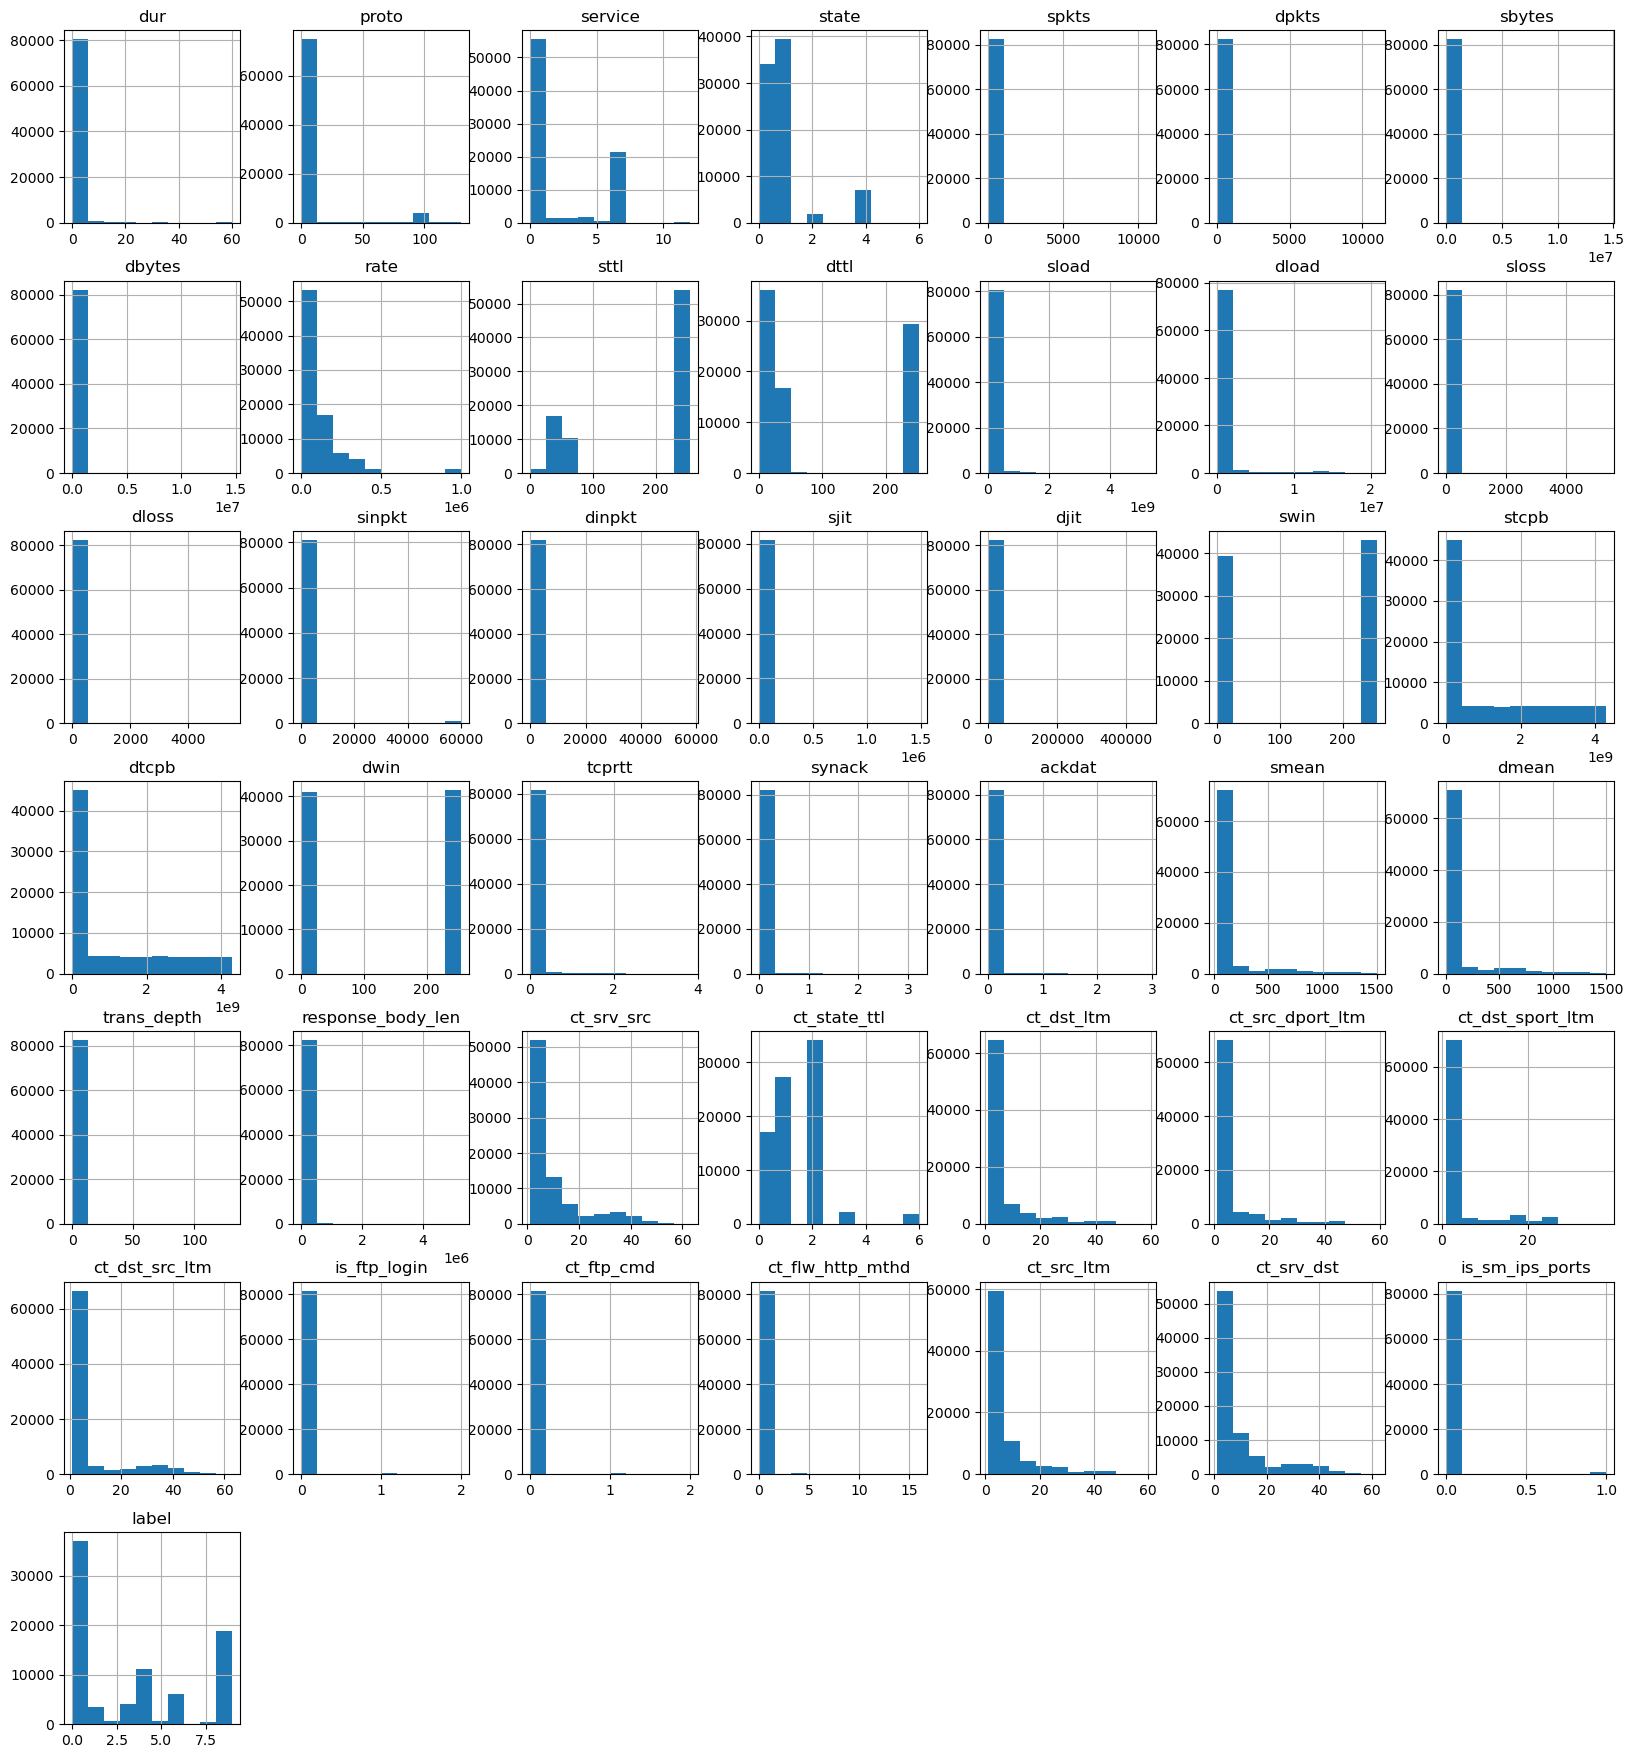

In [8]:
rcParams["figure.figsize"]=(20,22)
train_df.hist()
plt.grid()

In [9]:
spark = SparkSession.builder.appName("CSCI316GP2").getOrCreate()

# Convert the preprocessed training data into a Spark DataFrame
spark_train_df = spark.createDataFrame(train_df)
spark_test_df = spark.createDataFrame(test_df)

Feature Enabler

In [10]:
pipeline = SparkDFPipeline(smote=False, standardize=False)
train, test = pipeline.transform(spark_train_df, spark_test_df)

pipeline = SparkDFPipeline(smote=False, standardize=True)
FT_train, FT_test = pipeline.transform(spark_train_df, spark_test_df)

# Index the label column
label_indexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(FT_train)
label_indexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(FT_train)

Py4JJavaError: An error occurred while calling o138.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 10 in stage 0.0 failed 1 times, most recent failure: Lost task 10.0 in stage 0.0 (TID 10) (LAPTOP-F3C431LJ executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\spark\spark-3.4.1-bin-hadoop3\python\lib\pyspark.zip\pyspark\worker.py", line 683, in main
RuntimeError: Python in worker has different version 3.11 than that in driver 3.10, PySpark cannot run with different minor versions. Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:561)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:767)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:749)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:514)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.sort(UnsafeExternalRowSorter.java:225)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$.$anonfun$prepareShuffleDependency$10(ShuffleExchangeExec.scala:369)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:888)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:888)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\spark\spark-3.4.1-bin-hadoop3\python\lib\pyspark.zip\pyspark\worker.py", line 683, in main
RuntimeError: Python in worker has different version 3.11 than that in driver 3.10, PySpark cannot run with different minor versions. Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:561)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:767)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:749)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:514)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.sort(UnsafeExternalRowSorter.java:225)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$.$anonfun$prepareShuffleDependency$10(ShuffleExchangeExec.scala:369)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:888)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:888)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)


# TRAINING MODEL

## Default RF model

In [ ]:
# # Train a RandomForest model
# default_rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="features", seed=42)

# # Create a pipeline
# pipeline = Pipeline(stages=[label_indexer, default_rf])

# # Train the pipeline
# default_model = pipeline.fit(train)

## Accuracy of Basic RF Model

In [ ]:
# # Make predictions on the test data
# predictions = default_model.transform(test)

# # Create an evaluator for accuracy
# accuracy_evaluator = MulticlassClassificationEvaluator(
#     labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
# accuracy = accuracy_evaluator.evaluate(predictions)
# print("Accuracy = %g" % accuracy)

# # Create an evaluator for f1 score
# f1_evaluator = MulticlassClassificationEvaluator(
#     labelCol="indexedLabel", predictionCol="prediction", metricName="f1")
# f1_score = f1_evaluator.evaluate(predictions)
# print("F1 Score = %g" % f1_score)

# # Create an evaluator for precision
# precision_evaluator = MulticlassClassificationEvaluator(
#     labelCol="indexedLabel", predictionCol="prediction", metricName="weightedPrecision")
# precision = precision_evaluator.evaluate(predictions)
# print("Precision = %g" % precision)


## Fine tune RF

In [ ]:
# Train a RandomForest model
tuned_rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=20, maxDepth=5, impurity="gini", seed=42)

# # Set class weights using the "classWeights" parameter
# class_weights = {0: 1.0, 1: 2.0, 2: 1.5}  # Replace with your own class weights
# tuned_rf.setClassWeights(class_weights)

# # Define the parameter grid
# param_grid = ParamGridBuilder() \
#             .addGrid(tuned_rf.numTrees, [20]) \
#             .addGrid(tuned_rf.maxDepth, [5]) \
#             .addGrid(tuned_rf.impurity, ['gini']) \
#             .build()#30,50 #8,10 #'entropy'

# # Create a CrossValidator instance
# crossval = CrossValidator(estimator=pipeline,
#                           estimatorParamMaps=param_grid,
#                           evaluator=accuracy_evaluator,
#                           numFolds=3)  # Number of cross-validation folds

# # Run cross-validation, and choose the best set of parameters
# tuned_model = crossval.fit(FT_train)
# best_model = tuned_model.bestModel
# Train the pipeline

tuned_model = tuned_rf.fit(FT_train)
best_params = tuned_model.extractParamMap()
print("Best model params:", best_params)

## Accuracy of Fine Tune

In [ ]:
# Make predictions on the test data
best_predictions = tuned_model.transform(FT_test)

# Create an evaluator for accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
best_accuracy = accuracy_evaluator.evaluate(best_predictions)
print("Accuracy = %g" % best_accuracy)

# Create an evaluator for f1 score
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1")
best_f1_score = f1_evaluator.evaluate(best_predictions)
print("F1 Score = %g" % best_f1_score)

# Create an evaluator for precision
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
best_precision = precision_evaluator.evaluate(best_predictions)
print("Precision = %g" % best_precision)

In [ ]:
from sklearn.metrics import confusion_matrix
# Sample usage 
# Evaluate models using the evaluate_model function
evaluation_results_default = evaluate_model(default_model, test, 'Default Model')  # Use the 'test' dataset

# Evaluate models using the evaluate_model function
evaluation_results_tuned = evaluate_model(tuned_model, FT_test, 'Fine-Tuned Model')  # Use the 'test' dataset

# Print evaluation results for both models side by side

print("Evaluation Results:")
print(f"{'Metric':<20}{'Default Model':<20}{'Fine-Tuned Model':<20}")
print("=" * 60)

for metric in evaluation_results_default.keys():
    default_value = evaluation_results_default[metric]
    tuned_value = evaluation_results_tuned[metric]
    print(f"{metric:<20}{default_value:<20}{tuned_value:<20}")

In [ ]:
# spark.stop()